<a href="https://colab.research.google.com/github/Ashkar077/Bootcamp/blob/main/Project_Anoma_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import LocalOutlierFactor
import joblib

# Load the Dataset:

In [37]:
df = pd.read_csv("/content/AnomaData.csv")

# Exploratory Data Analysis (EDA):

Dataset summery and information

In [38]:
print("Dataset Information:")
print(df.info())
print("\nStatistical Summary:")
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18398 non-null  object 
 1   y       18398 non-null  int64  
 2   x1      18398 non-null  float64
 3   x2      18398 non-null  float64
 4   x3      18398 non-null  float64
 5   x4      18398 non-null  float64
 6   x5      18398 non-null  float64
 7   x6      18398 non-null  float64
 8   x7      18398 non-null  float64
 9   x8      18398 non-null  float64
 10  x9      18398 non-null  float64
 11  x10     18398 non-null  float64
 12  x11     18398 non-null  float64
 13  x12     18398 non-null  float64
 14  x13     18398 non-null  float64
 15  x14     18398 non-null  float64
 16  x15     18398 non-null  float64
 17  x16     18398 non-null  float64
 18  x17     18398 non-null  float64
 19  x18     18398 non-null  float64
 20  x19     18398 non-null  float64
 21  x20     18398 

## Checking for Missing Values

Identify any columns with missing values to handle them appropriately later.

In [39]:
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
time    0
y       0
x1      0
x2      0
x3      0
       ..
x57     0
x58     0
x59     0
x60     0
y.1     0
Length: 62, dtype: int64


# Class Distributions
Plot the distribution of the target variable 'y'

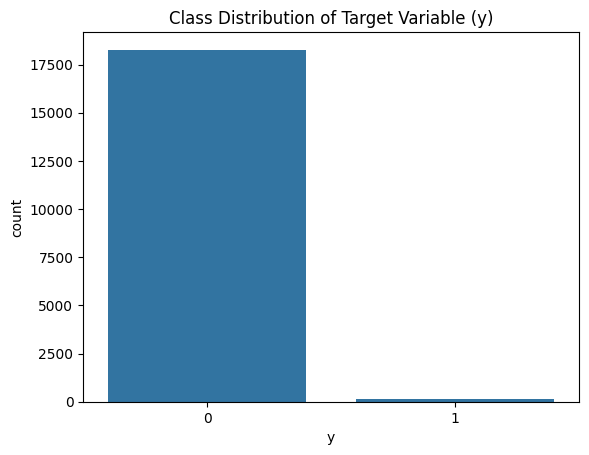

In [40]:
sns.countplot(x='y', data=df)
plt.title('Class Distribution of Target Variable (y)')
plt.show()

# Data Cleaning
Convert the 'time' column to datetime format for further processing

In [41]:
# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')
if df['time'].isnull().any():
    print("Warning: Some 'time' values could not be converted and will be dropped.")
    df.dropna(subset=['time'], inplace=True)

<ipython-input-41-b04f3d91e927>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['time'], errors='coerce')


# Visualize correlations (using only numeric columns)
Plot a heatmap to visualize correlations between numeric features

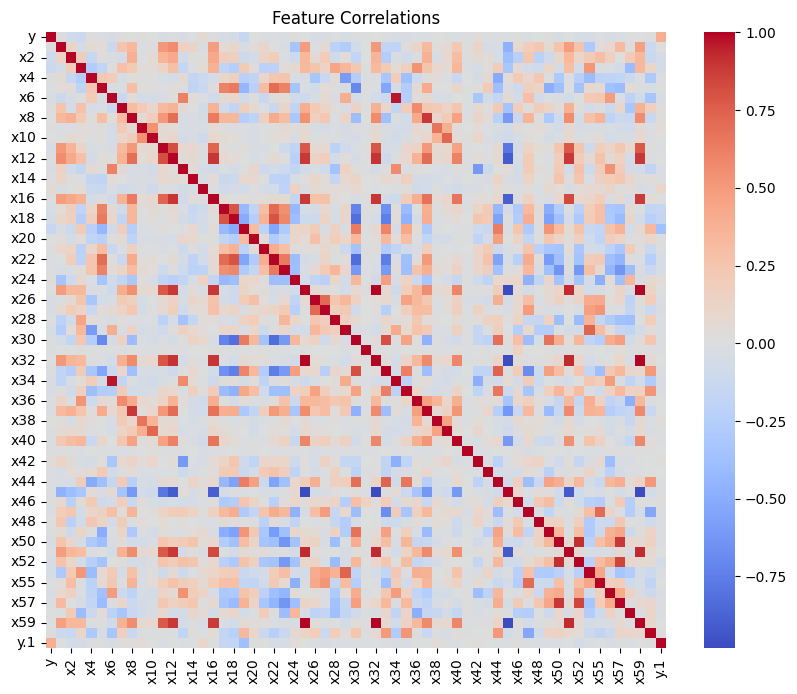

In [42]:
numeric_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlations')
plt.show()

# Data Cleaning

1.   Handling missing values
2.   Drop rows with missing values to ensure clean data
3.   Remove duplicates
4.   Detecting and Removing Outliers using Local Outlier Factor

In [43]:
df.dropna(inplace=True)

In [44]:
df = df.loc[:, ~df.columns.duplicated()]

In [45]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outliers = lof.fit_predict(numeric_df)
df = df[outliers != -1]

# Feature Engineering
1. Extract additional features from the 'time' column if it exists
2. Create new features from the 'time' column such as hour, day, and month if 'time' is present

In [46]:
if 'time' in df.columns:
    df.loc[:, 'hour'] = df['time'].dt.hour
    df.loc[:, 'day'] = df['time'].dt.day
    df.loc[:, 'month'] = df['time'].dt.month
    df.drop(['time'], axis=1, inplace=True)

<ipython-input-46-a0c90079d739>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'hour'] = df['time'].dt.hour
<ipython-input-46-a0c90079d739>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'day'] = df['time'].dt.day
<ipython-input-46-a0c90079d739>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

1. Splitting predictors and target variable
2. Separate the dataset into features (X) and target variable (y)

In [47]:
X = df.drop('y', axis=1)
y = df['y']

1. Feature Scaling using StandardScaler
2. Scale features to ensure they have similar ranges for better model performance

In [48]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

1. Handle Imbalanced Data using SMOTE
2. Use SMOTE to handle imbalanced data by oversampling the minority class

In [49]:
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

# Train/Test Split
Split the resampled data into training and testing sets (80% train, 20% test)

Print the value using shape function

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27806, 63)
X_test shape: (6952, 63)
y_train shape: (27806,)
y_test shape: (6952,)


# Model Selection, Validation, and Evaluation

We use three models, includes:

1. Random Forest (RF)

2. Gradient Booster (GB)

3. Logistic Regression (LR)

Tune all three models using Hyperparameter tuning. Use **GridSearchCV** to tune hyperparameters of the RandomForest, Gradient Booster, and Logistic Regression model for better performance.

Display the confusion matrix, classification report, and accuracy score for the model.

# Random Forest Classifier

In [90]:
random_forest = RandomForestClassifier(n_estimators=10, max_depth=2, random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

In [56]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[3120  323]
 [ 812 2697]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85      3443
           1       0.89      0.77      0.83      3509

    accuracy                           0.84      6952
   macro avg       0.84      0.84      0.84      6952
weighted avg       0.84      0.84      0.84      6952

Accuracy Score: 0.8367376294591484


## Hyperparameter Tuning (RF)

In [66]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [67]:
y_pred_best = best_model.predict(X_test)
print("Confusion Matrix (Tuned Model):")
print(confusion_matrix(y_test, y_pred_best))
print("Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_best))
print("Accuracy Score (Tuned Model):", accuracy_score(y_test, y_pred_best))

Confusion Matrix (Tuned Model):
[[3437    6]
 [   1 3508]]
Classification Report (Tuned Model):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3443
           1       1.00      1.00      1.00      3509

    accuracy                           1.00      6952
   macro avg       1.00      1.00      1.00      6952
weighted avg       1.00      1.00      1.00      6952

Accuracy Score (Tuned Model): 0.9989930955120828


# Gradient Boosting Classifier

In [69]:
gb_model = GradientBoostingClassifier(random_state=42)

In [70]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [71]:
y_pred_gb = gb_model.predict(X_test)

print("\nConfusion Matrix (Gradient Boosting):")
print(confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))
print("Accuracy Score (Gradient Boosting):", accuracy_score(y_test, y_pred_gb))


Confusion Matrix (Gradient Boosting):
[[3388   55]
 [  25 3484]]

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3443
           1       0.98      0.99      0.99      3509

    accuracy                           0.99      6952
   macro avg       0.99      0.99      0.99      6952
weighted avg       0.99      0.99      0.99      6952

Accuracy Score (Gradient Boosting): 0.9884925201380897


## Hyperparameter Tuning (GB)

In [74]:
gb_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
}

gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=2, n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train, y_train)

best_gb_model = gb_grid_search.best_estimator_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


In [75]:
y_pred_best_gb = best_gb_model.predict(X_test)
print("\nConfusion Matrix (Tuned Gradient Boosting):")
print(confusion_matrix(y_test, y_pred_best_gb))
print("\nClassification Report (Tuned Gradient Boosting):")
print(classification_report(y_test, y_pred_best_gb))
print("Accuracy Score (Tuned Gradient Boosting):", accuracy_score(y_test, y_pred_best_gb))


Confusion Matrix (Tuned Gradient Boosting):
[[3430   13]
 [   1 3508]]

Classification Report (Tuned Gradient Boosting):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3443
           1       1.00      1.00      1.00      3509

    accuracy                           1.00      6952
   macro avg       1.00      1.00      1.00      6952
weighted avg       1.00      1.00      1.00      6952

Accuracy Score (Tuned Gradient Boosting): 0.9979861910241657


# Logistic Regression

In [76]:
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

In [77]:
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [78]:
y_pred_logistic = logistic_model.predict(X_test)

print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logistic))
print("Accuracy Score (Logistic Regression):", accuracy_score(y_test, y_pred_logistic))


Confusion Matrix (Logistic Regression):
[[2922  521]
 [ 376 3133]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3443
           1       0.86      0.89      0.87      3509

    accuracy                           0.87      6952
   macro avg       0.87      0.87      0.87      6952
weighted avg       0.87      0.87      0.87      6952

Accuracy Score (Logistic Regression): 0.8709723820483314


## Hyperparameter Tuning (LR)

In [80]:
logistic_param_grid = {
    'C': [0.1, 1.0, 10.0],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2 regularization
}

logistic_grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), logistic_param_grid, cv=2, n_jobs=-1, verbose=2)
logistic_grid_search.fit(X_train, y_train)
best_logistic_model = logistic_grid_search.best_estimator_

Fitting 2 folds for each of 6 candidates, totalling 12 fits


In [81]:
y_pred_best_logistic = best_logistic_model.predict(X_test)
print("\nConfusion Matrix (Tuned Logistic Regression):")
print(confusion_matrix(y_test, y_pred_best_logistic))
print("\nClassification Report (Tuned Logistic Regression):")
print(classification_report(y_test, y_pred_best_logistic))
print("Accuracy Score (Tuned Logistic Regression):", accuracy_score(y_test, y_pred_best_logistic))


Confusion Matrix (Tuned Logistic Regression):
[[2936  507]
 [ 365 3144]]

Classification Report (Tuned Logistic Regression):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3443
           1       0.86      0.90      0.88      3509

    accuracy                           0.87      6952
   macro avg       0.88      0.87      0.87      6952
weighted avg       0.88      0.87      0.87      6952

Accuracy Score (Tuned Logistic Regression): 0.8745684695051784


## ROC-AUC score and ROC Curve

ROC-AUC Score: 0.9205404102988316


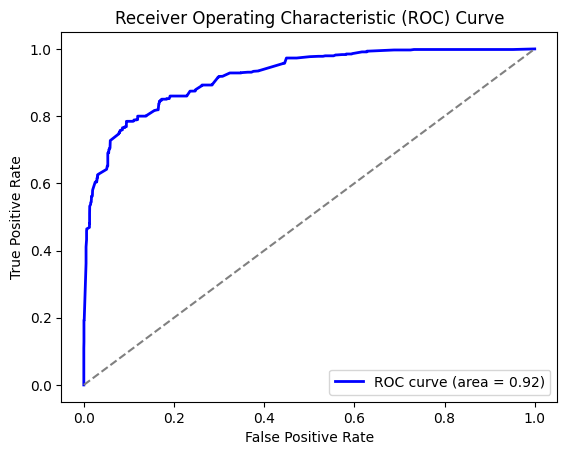

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
roc_auc = roc_auc_score(y_test, random_forest.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, random_forest.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC-AUC Score: 0.9988642954298589


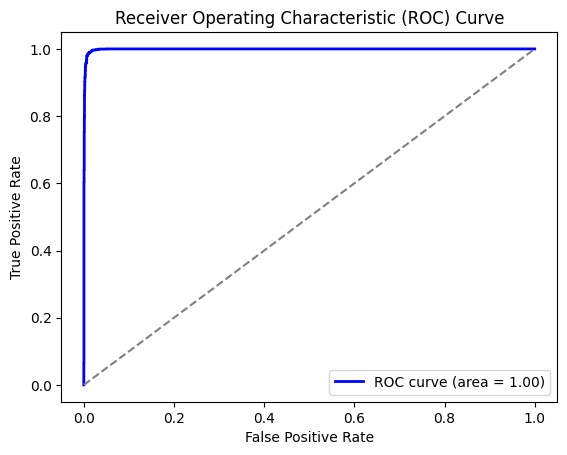

In [95]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
roc_auc = roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ROC-AUC Score: 0.9526500338906958


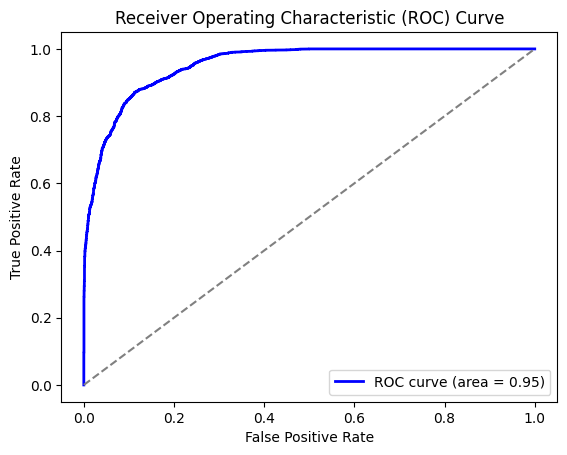

In [96]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)
fpr, tpr, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Model Deployment Plan

Convert the model into a serialized format (using joblib or pickle) and integrate it into an API for production use.

In [85]:
joblib.dump(best_model, 'predictive_maintenance_model.pkl')
print("Model saved as predictive_maintenance_model.pkl")

Model saved as predictive_maintenance_model.pkl


Save the actual and predicted values from the test set to a CSV file for further analysis

In [88]:
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Best': y_pred_best,
    'Predicted_Logistic': y_pred_best_logistic,
    'Predicted_GB': y_pred_best_gb
})

predictions_df.to_csv('predicted_results.csv', index=False)
print("Predicted results saved as predicted_results.csv")

Predicted results saved as predicted_results.csv
